### Description
- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL, PNEUMONIA).

### Problem Statement
- Detect Pneumonia From OCT Images.

### Constraints
- False Negative , is the biggest constraint for any medical based ML & DL based problems, we need to minimize this.
- Latancy is not the problem as tradition approches takes weeks.

### Benifits
- Predicting Pneumonia without using tradition or having domain expertise.

### Imprting Libraries

In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.initializers import he_normal, he_normal, GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import ResNet101, DenseNet121, VGG19, ResNet152V2
import os
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow, imsave, imread
from skimage.color import gray2rgb, rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Dataset Locations & Variables

In [2]:
train_dir = r'D:Datasets/pneu/train/'
val_dir = r'D:Datasets/pneu/val/'
test_dir = r'D:Datasets/pneu/test/'
img_height = 256
img_width = 256
channel = 3
BS = 32

### Data Augumentation

In [3]:
training_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2, vertical_flip = True,
                                      height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)   

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [4]:
train = training_datagen.flow_from_directory(train_dir, target_size = (img_height, img_width), batch_size = BS,
                                             class_mode = 'binary')

val = validation_datagen.flow_from_directory(val_dir, target_size = (img_height, img_width), batch_size = BS,
                                             class_mode = 'binary')

test = test_datagen.flow_from_directory(test_dir, target_size = (img_height, img_width), batch_size = BS,
                                        class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Sample Image

In [5]:
labs = {0 : 'Normal', 1: 'Pneumonia'}

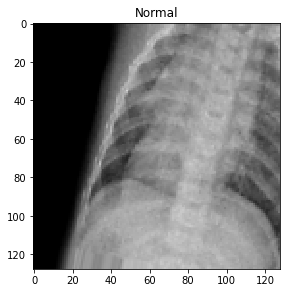

In [40]:
n = np.random.randint(0, len(train), 2)[0] 
imshow(train[n][0][0])
plt.title(labs.get(train[n][1][0]))
plt.show()

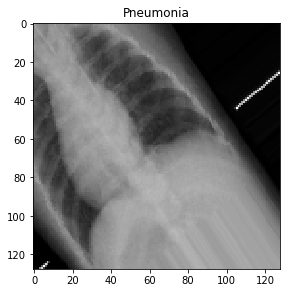

In [30]:
n = np.random.randint(0, len(train), 2)[0]
imshow(train[n][0][0])
plt.title(labs.get(train[n][1][0]))
plt.show()

### Dense Net Architecture

In [32]:
init_glor = GlorotUniform() 

model = Sequential()
base = DenseNet121(include_top = False, input_shape = (img_height, img_width, channel), pooling = 'avg', classes = 2)
for l in base.layers:
    l.trainable = False
    
model.add(base)

model.add(BatchNormalization())

model.add((Dense(256, activation = 'relu', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add((Dense(128, activation = 'relu', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add((Dense(64, activation = 'relu', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add((Dense(32, activation = 'relu', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add((Dense(16, activation = 'relu', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add((Dense(1, activation = 'sigmoid', kernel_initializer = init_glor, kernel_regularizer = l2(0.00001))))

opt = Adam()

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

### Training

In [6]:
earlystoping = EarlyStopping(patience = 2, mode = 'min', restore_best_weights=True)

check = ModelCheckpoint('model1.h5', verbose = 1, save_best_only = True, mode = 'min')

model.fit(train, steps_per_epoch = 50, validation_data = val, validation_steps = 20, epochs = 200,
          callbacks = [earlystoping, check])

Epoch 1/500
50/50 [==============================] - 63s 975ms/step - loss: 1.1698 - accuracy: 0.4605 - val_loss: 0.7330 - val_accuracy: 0.3974

Epoch 00001: val_loss improved from inf to 0.73297, saving model to model1.h5
Epoch 2/500
50/50 [==============================] - 45s 913ms/step - loss: 1.0384 - accuracy: 0.5212 - val_loss: 0.7134 - val_accuracy: 0.5064

Epoch 00002: val_loss improved from 0.73297 to 0.71341, saving model to model1.h5
Epoch 3/500
50/50 [==============================] - 46s 927ms/step - loss: 0.9598 - accuracy: 0.5382 - val_loss: 0.6910 - val_accuracy: 0.5657

Epoch 00003: val_loss improved from 0.71341 to 0.69101, saving model to model1.h5
Epoch 4/500
50/50 [==============================] - 47s 938ms/step - loss: 0.8736 - accuracy: 0.5479 - val_loss: 0.6687 - val_accuracy: 0.6298

Epoch 00004: val_loss improved from 0.69101 to 0.66871, saving model to model1.h5
Epoch 5/500
50/50 [==============================] - 44s 888ms/step - loss: 0.8543 - accuracy: 0

### Model Evalutaion

In [8]:
model = load_model('pneu.h5')

In [10]:
model.evaluate(test)

1/1 [==============================] - 7s 7s/step - loss: 0.4419 - accuracy: 0.8125


[0.44186991453170776, 0.8125]

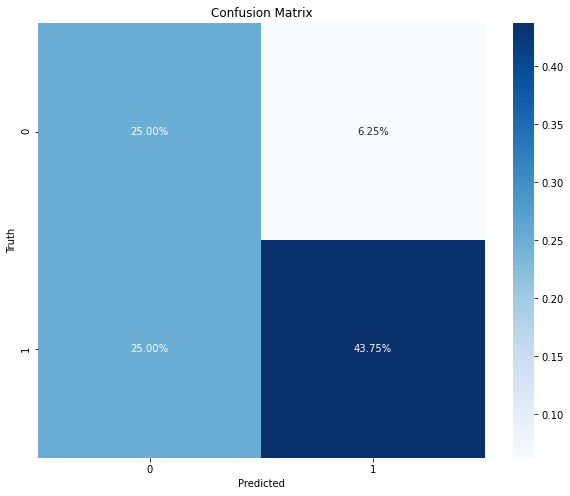

In [35]:
cnm = confusion_matrix(model.predict_classes(test), test.labels)
plt.figure(figsize = (10, 8))
sns.heatmap(cnm/np.sum(cnm), annot = True, fmt = '.2%', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

### Prediction

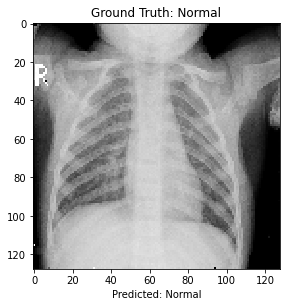

In [13]:
ran = np.random.randint(0, len(test))
pred = (model.predict_classes(test[ran][0][0].reshape(1, img_height, img_width, 3)))[0][0]
plt.figure(figsize = (10 , 4))
imshow(test[ran][0][0])
pred = 'Predicted: ' + str(labs.get(pred))
true = 'Ground Truth: ' + str(labs.get(test[ran][1][0]))
plt.title(true)
plt.xlabel(pred)
plt.show()